In [14]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video
from tetris_gymnasium.envs.tetris import Tetris

### **Wrapper**

In [15]:
import gymnasium as gym
import numpy as np

class TetrisObsWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        # Define final observation space (4 channels, 24x18)
        self.observation_space = gym.spaces.Box(
            low=0,
            high=1,
            shape=(4, 24, 18),
            dtype=np.float32,
        )

    def observation(self, obs):
        board = obs["board"].astype(np.float32) / 9.0
        mask = obs["active_tetromino_mask"].astype(np.float32)
        holder = obs["holder"].astype(np.float32) / 9.0
        queue = obs["queue"].astype(np.float32) / 9.0

        # pad holder to (24, 18)
        holder_padded = np.zeros((24, 18), dtype=np.float32)
        holder_padded[:holder.shape[0], :holder.shape[1]] = holder

        # pad or crop queue safely to fit (24, 18)
        queue_padded = np.zeros((24, 18), dtype=np.float32)
        h, w = queue.shape
        queue_padded[:min(4, h), :min(18, w)] = queue[:min(4, h), :min(18, w)]

        # stack all channels
        stacked = np.stack([board, mask, holder_padded, queue_padded], axis=0)
        return stacked


In [16]:
#LIMIT ACTION SPACE TO RELEVANT ACTIONS ONLY

import gymnasium as gym
import numpy as np

class ActionFilterWrapper(gym.ActionWrapper):
    def __init__(self, env, allowed_actions):
        super().__init__(env)
        self.allowed_actions = allowed_actions
        self.action_map = {i: a for i, a in enumerate(self.allowed_actions)}
        # update action space to match the number of allowed actions
        self.action_space = gym.spaces.Discrete(len(self.allowed_actions))

    def action(self, act):
        # map from filtered index to actual env action
        return self.action_map[act]


In [17]:
# def height_penalty(board):
#     """
#     board: 2D numpy array (24x18) of current Tetris board
#     returns: negative value proportional to height
#     """
#     # consider only main playfield (20x10)
#     playfield = board[:20, 4:14]  # adjust if necessary
#     heights = playfield.sum(axis=0)  # sum of each column
#     max_height = np.max(heights)
    
#     # penalty: higher stack = more negative
#     return -0.1 * max_height

In [18]:
# class TetrominoFilterWrapper(gym.Wrapper):
#     def __init__(self, env, allowed_ids=(2,3)):
#         super().__init__(env)
#         self.allowed_ids = allowed_ids

#         # Filter environment's tetromino pool
#         if hasattr(env.unwrapped, "base_tetrominoes"):
#             env.unwrapped.base_tetrominoes = tuple(
#                 [t for t in env.unwrapped.base_tetrominoes if t.id in allowed_ids]
#             )

#     def reset(self, **kwargs):
#         obs, info = self.env.reset(**kwargs)
#         obs = self._filter_queue(obs)
#         return obs, info

#     def step(self, action):
#         obs, reward, terminated, truncated, info = self.env.step(action)
#         obs = self._filter_queue(obs)
#         return obs, reward, terminated, truncated, info

#     def _filter_queue(self, obs):
#         queue = obs.get("queue")
#         if queue is not None:
#             mask = ~np.isin(queue, self.allowed_ids)
#             queue[mask] = 0
#             obs["queue"] = queue
#         return obs


### **Neural Network (DQN)**

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super(DQN, self).__init__()
        C, H, W = obs_shape  # e.g. (4, 24, 18)

        # Safer kernel/stride combo for small inputs
        self.conv = nn.Sequential(
            nn.Conv2d(C, 32, kernel_size=3, stride=1, padding=1),  # keeps 24x18
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # halves size
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # halves again
            nn.ReLU(),
        )

        # Automatically compute flattened conv output size
        with torch.no_grad():
            dummy = torch.zeros(1, C, H, W)
            conv_out = self.conv(dummy)
            conv_out_size = conv_out.view(1, -1).size(1)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


### **ReplayBuffer**

In [20]:
class ReplayMemory:
    def __init__(self, capacity, device):
        self.memory = deque(maxlen=capacity)
        self.device = device  # 'cuda' or 'cpu'

    def push(self, state, action, reward, next_state, done):
        # Store raw (numpy or list) to save memory instead of storing tensors directly
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors and pin memory for faster GPU transfer
        states = torch.tensor(np.array(states), dtype=torch.float32).pin_memory()
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32).pin_memory()
        actions = torch.tensor(actions, dtype=torch.long).pin_memory()
        rewards = torch.tensor(rewards, dtype=torch.float32).pin_memory()
        dones = torch.tensor(dones, dtype=torch.float32).pin_memory()

        # Transfer to GPU asynchronously for speed
        return (
            states.to(self.device, non_blocking=True),
            actions.to(self.device, non_blocking=True),
            rewards.to(self.device, non_blocking=True),
            next_states.to(self.device, non_blocking=True),
            dones.to(self.device, non_blocking=True)
        )

    def __len__(self):
        return len(self.memory)

### **Training**

#### *Two-Phase Training*

In [21]:
def train_dqn(episodes, batch_size, gamma, lr, 
              epsilon_start, epsilon_end, epsilon_decay, 
              target_update, buffer_size):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    env = gym.make("tetris_gymnasium/Tetris", render_mode="ansi")
    env = ActionFilterWrapper(env, allowed_actions=[0, 1, 2, 3, 4, 5]) # (remove swap=6 and no_op=7)  
    env = TetrisObsWrapper(env)

    obs, _ = env.reset()
    obs_shape = obs.shape
    num_actions = env.action_space.n

    policy_net = DQN(obs_shape, num_actions).to(device)
    target_net = DQN(obs_shape, num_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayMemory(buffer_size, device=device)

    steps_done = 0
    rewards_history = []

    # ---- Cyclic Training Parameters ----
    cycle_length = 1000       # total cycle = 1000 episodes
    phase_length = cycle_length // 2  # 500 explore + 500 exploit

    for ep in range(episodes):
        # Determine which phase we're in
        cycle_pos = ep % cycle_length
        in_explore_phase = cycle_pos < phase_length

        # Phase settings
        if in_explore_phase:
            # 🔹 High Exploration Phase
            eps_high, eps_low = 0.3, 0.0001
            lr_high, lr_low = 0.01, 0.001
            phase_pos = cycle_pos / phase_length
        else:
            # 🔸 High Exploitation Phase
            eps_high, eps_low = 0.0001, 0.0001
            lr_high, lr_low = 0.001, 0.001
            phase_pos = (cycle_pos - phase_length) / phase_length

        # Smooth interpolation (linear)
        epsilon = eps_high + (eps_low - eps_high) * phase_pos
        current_lr = lr_high + (lr_low - lr_high) * phase_pos

        # Update optimizer LR dynamically
        for g in optimizer.param_groups:
            g['lr'] = current_lr

        # ---- Start Episode ----
        state, _ = env.reset()
        state = np.array(state)
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                with torch.no_grad():
                    action = policy_net(s).argmax(1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.array(next_state)
            done = terminated or truncated

            memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps_done += 1

            # Learn
            if len(memory) > batch_size:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)
                states, next_states = states.to(device), next_states.to(device)
                actions, rewards, dones = actions.to(device), rewards.to(device), dones.to(device)

                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                next_q_values = target_net(next_states).max(1)[0]
                targets = rewards + gamma * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Update target net periodically
            if steps_done % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

        rewards_history.append(total_reward)

        print(f"Ep {ep:4d} | Phase: {'Explore' if in_explore_phase else 'Exploit'} "
              f"| Eps: {epsilon:.5f} | LR: {current_lr:.5f} | Reward: {total_reward:.3f}")

    env.close()
    return policy_net, rewards_history


In [22]:
# def train_dqn(episodes, batch_size, gamma, lr, 
#               epsilon_start, epsilon_end, epsilon_decay, 
#               target_update, buffer_size):
    
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     env = gym.make("tetris_gymnasium/Tetris", render_mode="ansi")
#     env = ActionFilterWrapper(env, allowed_actions=[0, 1, 2, 3, 4, 5]) # (remove swap=6 and no_op=7)            
#     env = TetrisObsWrapper(env)

#     obs, _ = env.reset()
#     obs_shape = obs.shape
#     num_actions = env.action_space.n

#     policy_net = DQN(obs_shape, num_actions).to(device)  # Main network
#     target_net = DQN(obs_shape, num_actions).to(device)  # Target network (copy)
#     target_net.load_state_dict(policy_net.state_dict())  # Sync weights initially
#     optimizer = optim.Adam(policy_net.parameters(), lr=lr)
#     memory = ReplayMemory(buffer_size, device=device)

#     steps_done = 0
#     epsilon = epsilon_start
#     rewards_history = []
    
#     for ep in range(episodes):
#         state, _ = env.reset()
#         state = np.array(state)

#         done = False
#         # reward_history
#         total_reward = 0

#         while not done:
#             # Epsilon-greedy action
#             epsilon = epsilon_end + (epsilon_start - epsilon_end) * \
#                     np.exp(-1. * steps_done / epsilon_decay)

#             if random.random() < epsilon:
#                 action = env.action_space.sample()
#             else:
#                 s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).cuda()
#                 with torch.no_grad():
#                     action = policy_net(s).argmax(1).item()

#             next_state, reward, terminated, truncated, _ = env.step(action)
#             next_state = np.array(next_state)
#             done = terminated or truncated
            
#             # # Reward Shaping

#             shaped_reward = reward
            
#             # if reward == 0:
#             #     shaped_reward = -0.1   # tiny penalty for no progress

#             # if reward > 0:
#             #     shaped_reward = 10 * (reward ** 2)  # clearing multiple lines (e.g. 10, 40, 90, 160)

#             # else:
#             #     shaped_reward = reward

#             memory.push(state, action, shaped_reward, next_state, done)
#             state = next_state
#             total_reward += reward
#             steps_done += 1

#             # Learn
#             if len(memory) > batch_size:
#                 states, actions, rewards, next_states, dones = memory.sample(batch_size)

#                 states, next_states = states.cuda(), next_states.cuda()
#                 actions, rewards, dones = actions.cuda(), rewards.cuda(), dones.cuda()

#                 q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
#                 next_q_values = target_net(next_states).max(1)[0]
#                 targets = rewards + gamma * next_q_values * (1 - dones)

#                 loss = nn.MSELoss()(q_values, targets)

#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             # Update target net
#             if steps_done % target_update == 0:
#                 target_net.load_state_dict(policy_net.state_dict())

#         rewards_history.append(total_reward)
        
#         # if ep % 50 == 0:
#         print(f"Episode {ep}, Reward: {total_reward:.3f}, Epsilon: {epsilon:.2f}")
#         # print("--")
        
#         # if ep % 500 == 0:
#         #     torch.save(policy_net.state_dict(), f"checkpoints/tetris_dqn_ep{ep}.pth")

#     env.close()
#     return policy_net, rewards_history


In [23]:
# locate the path of the reward mapping file

import tetris_gymnasium.mappings.rewards as rewards
print(rewards.__file__)

c:\Users\Lenovo\.conda\envs\rl_finals\lib\site-packages\tetris_gymnasium\mappings\rewards.py


In [24]:
from tetris_gymnasium.mappings.rewards import RewardsMapping
rewards_mapping = RewardsMapping()
print(rewards_mapping)

RewardsMapping(alife=0.001, clear_line=1, game_over=-2, invalid_action=-0.1)


## **Comparison of Default Parameters to Tuned Parameters**

### *Default Parameter*

In [25]:
# parameters

params_default = {
    "episodes": 1000,          # short training duration
    "batch_size": 32,          # small batch, faster but noisier updates
    "gamma": 0.99,             # typical default discount factor
    "lr": 0.01,              # faster learning rate (less stable)
    "epsilon_start": 1.0,      # full exploration at start
    "epsilon_end": 0.3,        # mild exploration at the end
    "epsilon_decay": 20000,     # fast decay (less exploration overall)
    "target_update": 1000,     # frequent target refreshes
    "buffer_size": 5000      # smaller replay buffer
}


In [26]:
q_net, rewards = train_dqn(**params_default)

Ep    0 | Phase: Explore | Eps: 0.30000 | LR: 0.01000 | Reward: -1.990
Ep    1 | Phase: Explore | Eps: 0.29940 | LR: 0.00998 | Reward: -1.991
Ep    2 | Phase: Explore | Eps: 0.29880 | LR: 0.00996 | Reward: -1.988
Ep    3 | Phase: Explore | Eps: 0.29820 | LR: 0.00995 | Reward: -1.989
Ep    4 | Phase: Explore | Eps: 0.29760 | LR: 0.00993 | Reward: -1.990
Ep    5 | Phase: Explore | Eps: 0.29700 | LR: 0.00991 | Reward: -1.990
Ep    6 | Phase: Explore | Eps: 0.29640 | LR: 0.00989 | Reward: -1.989
Ep    7 | Phase: Explore | Eps: 0.29580 | LR: 0.00987 | Reward: -1.986
Ep    8 | Phase: Explore | Eps: 0.29520 | LR: 0.00986 | Reward: -1.987
Ep    9 | Phase: Explore | Eps: 0.29460 | LR: 0.00984 | Reward: -1.991
Ep   10 | Phase: Explore | Eps: 0.29400 | LR: 0.00982 | Reward: -1.988
Ep   11 | Phase: Explore | Eps: 0.29340 | LR: 0.00980 | Reward: -1.989
Ep   12 | Phase: Explore | Eps: 0.29280 | LR: 0.00978 | Reward: -1.986
Ep   13 | Phase: Explore | Eps: 0.29220 | LR: 0.00977 | Reward: -1.988
Ep   1

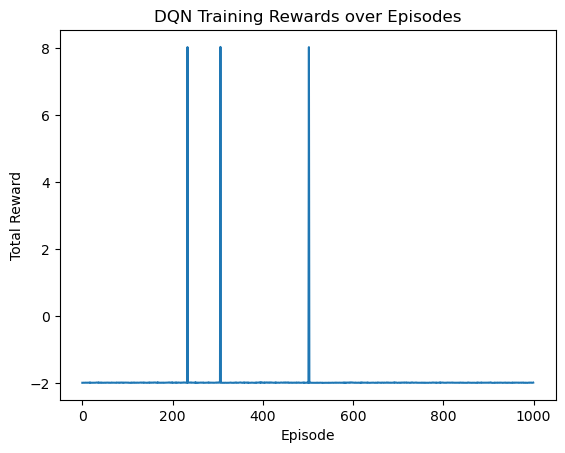

In [27]:
# Plot rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Rewards over Episodes')
plt.show()

#### Video Recording (Default)

In [28]:
import imageio
import torch
import gymnasium as gym
import numpy as np
import os
import re

env = gym.make("tetris_gymnasium/Tetris", render_mode="rgb_array")  # use rgb_array for frames
env = ActionFilterWrapper(env, allowed_actions=[0, 1, 2, 3, 4, 5]) # (remove swap=6 and no_op=7)  
env = TetrisObsWrapper(env)

# Folder for saving videos
video_dir = "tetris_videos"
os.makedirs(video_dir, exist_ok=True)

# Pattern: tetris_dqn_<number>.mp4
existing = [
    f for f in os.listdir(video_dir)
    if re.match(r"tetris_dqn_default-params_(\d+)\.mp4", f)
]

if existing:
    # Extract numbers from filenames and find the largest one
    last_num = max(int(re.search(r"tetris_dqn_default-params_(\d+)\.mp4", f).group(1)) for f in existing)
    next_num = last_num + 1
else:
    next_num = 1

# Build next video filename
video_path = os.path.join(video_dir, f"tetris_dqn_default-params_{next_num}.mp4")
writer = imageio.get_writer(video_path, fps=30)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_net.eval()

for ep in range(10):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        # convert state (numpy) to torch tensor and add batch dim
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            action = q_net(state_tensor).argmax(1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        # render as rgb_array and write to video
        frame = env.render()
        writer.append_data(frame)

        state = next_state

    print(f"Episode {ep + 1} finished with reward {total_reward:.3f}")

writer.close()
env.close()
print(f"🎬 Video saved to {video_path}")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (340, 240) to (352, 240) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 1 finished with reward -1.989
Episode 2 finished with reward -1.989
Episode 3 finished with reward -1.987
Episode 4 finished with reward -1.988
Episode 5 finished with reward -1.990
Episode 6 finished with reward -1.989
Episode 7 finished with reward -1.990
Episode 8 finished with reward -1.988
Episode 9 finished with reward -1.990
Episode 10 finished with reward -1.989
🎬 Video saved to tetris_videos\tetris_dqn_default-params_15.mp4


In [28]:
Video("tetris_videos/tetris_dqn_default-params_5.mp4", embed=True)

### *Tuned Parameters*

In [30]:
tuned_params = {
    "episodes": 2000,          # short training duration
    "batch_size": 64,          # small batch, faster but noisier updates
    "gamma": 0.99,             # typical default discount factor
    "lr": 0.001,              # faster learning rate (less stable)
    "epsilon_start": 1.0,      # full exploration at start
    "epsilon_end": 0.05,        # mild exploration at the end
    "epsilon_decay": 25000,     # fast decay (less exploration overall)
    "target_update": 1000,     # frequent target refreshes
    "buffer_size": 3000      # smaller replay buffer
}

In [31]:
# GGZ!!
 
q_net, rewards = train_dqn(**tuned_params)

Episode 0, Reward: -4.890, Epsilon: 1.00
Episode 1, Reward: -4.880, Epsilon: 0.99
Episode 2, Reward: -4.900, Epsilon: 0.99
Episode 3, Reward: -4.880, Epsilon: 0.99
Episode 4, Reward: -4.900, Epsilon: 0.99
Episode 5, Reward: -4.910, Epsilon: 0.99
Episode 6, Reward: -4.890, Epsilon: 0.98
Episode 7, Reward: -4.910, Epsilon: 0.98
Episode 8, Reward: -4.880, Epsilon: 0.98
Episode 9, Reward: -4.910, Epsilon: 0.98
Episode 10, Reward: -4.900, Epsilon: 0.97
Episode 11, Reward: -4.900, Epsilon: 0.97
Episode 12, Reward: -4.900, Epsilon: 0.97
Episode 13, Reward: -4.900, Epsilon: 0.97
Episode 14, Reward: -4.910, Epsilon: 0.97
Episode 15, Reward: -4.920, Epsilon: 0.96
Episode 16, Reward: -4.890, Epsilon: 0.96
Episode 17, Reward: -4.890, Epsilon: 0.96
Episode 18, Reward: -4.890, Epsilon: 0.96
Episode 19, Reward: -4.900, Epsilon: 0.96
Episode 20, Reward: -4.910, Epsilon: 0.95
Episode 21, Reward: -4.900, Epsilon: 0.95
Episode 22, Reward: -4.920, Epsilon: 0.95
Episode 23, Reward: -4.880, Epsilon: 0.95
Ep

In [1]:
# Plot rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Rewards over Episodes')
plt.show()

NameError: name 'plt' is not defined

#### Video Recording (Default)

In [33]:
import imageio
import torch
import gymnasium as gym
import numpy as np
import os
import re

env = gym.make("tetris_gymnasium/Tetris", render_mode="rgb_array")  # use rgb_array for frames
env = TetrisObsWrapper(env)

# Folder for saving videos
video_dir = "tetris_videos"
os.makedirs(video_dir, exist_ok=True)

# Pattern: tetris_dqn_<number>.mp4
existing = [
    f for f in os.listdir(video_dir)
    if re.match(r"tetris_dqn_tuned-params_(\d+)\.mp4", f)
]

if existing:
    # Extract numbers from filenames and find the largest one
    last_num = max(int(re.search(r"tetris_dqn_tuned-params_(\d+)\.mp4", f).group(1)) for f in existing)
    next_num = last_num + 1
else:
    next_num = 1

# Build next video filename
video_path = os.path.join(video_dir, f"tetris_dqn_tuned-params_{next_num}.mp4")
writer = imageio.get_writer(video_path, fps=30)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_net.eval()

for ep in range(10):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        # convert state (numpy) to torch tensor and add batch dim
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            action = q_net(state_tensor).argmax(1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        # render as rgb_array and write to video
        frame = env.render()
        writer.append_data(frame)

        state = next_state

    print(f"Episode {ep + 1} finished with reward {total_reward:.3f}")

writer.close()
env.close()
print(f"🎬 Video saved to {video_path}")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (340, 240) to (352, 240) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 1 finished with reward -4.900
Episode 2 finished with reward -4.910
Episode 3 finished with reward -4.900
Episode 4 finished with reward -4.910
Episode 5 finished with reward -4.880
Episode 6 finished with reward -4.900
Episode 7 finished with reward -4.910
Episode 8 finished with reward -4.900
Episode 9 finished with reward -4.890
Episode 10 finished with reward -4.900
🎬 Video saved to tetris_videos\tetris_dqn_tuned-params_3.mp4


In [17]:
Video("tetris_videos/tetris_dqn_tuned-params_2.mp4", embed=True)

### **Actor Critic**

In [19]:
# # =============================
# # 📊 Evaluate trained Tetris DQN agent
# # =============================

# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# import gymnasium as gym
# from collections import defaultdict

# # --- define evaluation function ---
# def evaluate_agent(policy_net,
#                    env_fn,
#                    n_episodes=100,
#                    device='cuda' if torch.cuda.is_available() else 'cpu',
#                    render=False,
#                    render_mode='ansi',
#                    collect_shaped=True):

#     policy_net.eval()
#     stats = defaultdict(list)

#     for ep in range(n_episodes):
#         env = env_fn()
#         obs, _ = env.reset()
#         state = np.array(obs, dtype=np.float32)
#         done = False
#         total_reward = 0.0
#         total_shaped = 0.0 if collect_shaped else None
#         steps = 0

#         with torch.no_grad():
#             while not done:
#                 s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
#                 q_values = policy_net(s)
#                 action = q_values.argmax(1).item()

#                 next_obs, reward, terminated, truncated, info = env.step(action)
#                 next_state = np.array(next_obs, dtype=np.float32)
#                 done = terminated or truncated

#                 total_reward += reward
#                 if collect_shaped:
#                     shaped = -0.01 if reward == 0 else reward * 10
#                     total_shaped += shaped

#                 state = next_state
#                 steps += 1

#         env.close()

#         stats['episode_reward_raw'].append(total_reward)
#         if collect_shaped:
#             stats['episode_reward_shaped'].append(total_shaped)
#         stats['episode_steps'].append(steps)

#         print(f"Episode {ep+1}/{n_episodes} | Lines Cleared: {total_reward:.0f} | Steps: {steps}")

#     # --- summary metrics ---
#     metrics = {
#         'mean_reward_raw': np.mean(stats['episode_reward_raw']),
#         'std_reward_raw': np.std(stats['episode_reward_raw']),
#         'max_reward_raw': np.max(stats['episode_reward_raw']),
#         'mean_steps': np.mean(stats['episode_steps'])
#     }
#     if collect_shaped:
#         metrics['mean_reward_shaped'] = np.mean(stats['episode_reward_shaped'])

#     print("\n=== Evaluation Summary ===")
#     for k, v in metrics.items():
#         print(f"{k:20s}: {v:.2f}")

#     # --- plot ---
#     plt.figure(figsize=(10,4))
#     plt.plot(stats['episode_reward_raw'], label='Raw (Lines Cleared)')
#     if collect_shaped:
#         plt.plot(stats['episode_reward_shaped'], label='Shaped Reward')
#     plt.xlabel('Episode')
#     plt.ylabel('Reward')
#     plt.title('DQN Evaluation over 100 Episodes')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return metrics, stats


# # --- run evaluation ---
# env_ctor = lambda: TetrisObsWrapper(gym.make("tetris_gymnasium/Tetris", render_mode="ansi"))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # replace `q_net` with whatever your trained model variable name is
# metrics, stats = evaluate_agent(q_net, env_ctor, n_episodes=1000, device=device, collect_shaped=True)
